# T09P02 - MdSM

# CASO DE ESTUDIO 2: Tiempo crítico de despeje de una falta trifásica en el punto medio de la línea B (de un conjunto de dos líneas en paralelo) y que se despeja por apertura de la misma (ANÁLISIS EN EL DOMINIO DEL TIEMPO).

## Enunciado

Determine el ángulo crítico de despeje de una falta trifásica en el punto medio de la línea B de un grupo de dos líneas en paralelo, y que se despeja por apertura de la misma.

Tome como datos:

- Potencia nominal del generador ($S_g$): 100 MVA.
- Tensión nominal en bornes del generador ($U_g$): 15 kV.
- Constante de inercia del generador ($H_g$): 3 s (Referida a la potencia del generador).
- Carga del generador previa a la falta: 100% potencia nominal.
- Factor de potencia del generador previo a la falta: $0.8$ inductivo.
- Reactancia transitoria del generador ($X'_g$): 0.3 pu.
- Potencia del transformador ($S_t$): 100 MVA.
- Reactancia de cc del transformador ($X_t$): 0.15 pu.
- Reactancia de la línea A ($X_{lA}$): 0.20 pu.
- Reactancia de la línea B ($X_{lB}$): 0.20 pu.
- Tensión del nudo de conexión ($U_{red}$): 220 kV.
- Potencia del nudo de conexión ($S_{red}$): infinita.

**Sistema eléctrico:**

![Esquema del sistema](T09P02_Fig00.png)

## Resolución

In [172]:
# Importar librerías genéricas:
import numpy as np
import cmath as cm
import matplotlib.pyplot as plt
import scipy.integrate as integrate
import scipy.optimize as optim

# Formato general de salida de resultados numéricos:
np.set_printoptions(precision=3, suppress=True)

### Datos del problema y transformación a valores por unidad

In [173]:
# Datos:
Sgen = 100 # MVA
Ugen = 15 # kV
H = 3 # s
Xgen = 0.3 # pu (transitoria)
Ured = 220 # kV
St = 100 # MVA
Xt = 0.15 # pu
Xl1 = 0.20 # pu
Xl2 = 0.20 # pu
dist_falta = 0.5 # Posición de la falta en la línea (distancia relativa desde cabecera)
FPgen = 0.8 # factor de potencia del generador
Gen = 1 # Régimen de carga del generador (tanto por uno)
f = 50 # Hz
omega_0 = 2*np.pi*f # Velocidad de sincronismo

# Transformación a magnitudes por unidad
Sbase = 100 # Potencia base
Ub1 = Ugen # Tensión base zona 1 (generador)
Ub2 = Ured # Tensión base zona 2 (red)
ugen = Ugen/Ub1
ured = Ured/Ub2
sgen = Sgen/Sbase
H = H*Sgen/Sbase # Constante de inercia referida a la potencia base del sistema.

D = 5 # pu (actor de amortiguamiento): 5 pu.
t_desp = 0.2 # s (tiempo crítico de despeje de la falta): 0.3791 s
t_pf = 2 # s (tiempo de simulación postfalta)

### Cálculo de impedancias de transferencia y potencias máximas transmisibles

In [174]:
# Corriente inyectada por el generador antes de la falta:
sgen_comp = sgen*Gen*(FPgen+cm.sin(np.arccos(FPgen))*1j)
igen = sgen_comp/ugen
igen = igen.conjugate()

# Tensión detrás de la reactancia transitoria del generador respecto de los bornes del mismo:
egen = ugen + Xgen*1j*igen 

# Impedancia de transferencia antes de la falta:
Xe_pref = Xgen + Xt + Xl1*Xl2/(Xl1+Xl2)
print('Xe_pref = {:.3f} pu'.format(Xe_pref))

# Impedancia de transferencia en falta:
Xe_f = Xgen + Xt + Xl1 + (Xgen + Xt)*Xl1/(dist_falta*Xl2)
print('Xe_f = {:.3f} pu'.format(Xe_f))

# Impedancia de transferencia después de la falta:
Xe_posf = Xgen + Xt + Xl1
print('Xe_posf = {:.3f} pu'.format(Xe_posf))

# Tensión del nodo de conexión a red respecto de los bornes del generador:
ured = ugen - (Xt + Xl1*Xl2/(Xl1 + Xl2))*1j*igen

# Ángulo relativo de la tensión detrás de la reactancia transitoria del generador con relación a la tensión del nudo de potencia infinita ANTES DE LA FALTA:
delta_pref = cm.phase(egen) - cm.phase(ured)
print('delta_pref = {:.3f} pu'.format(delta_pref*180/np.pi))

# Potencia máxima transmisible PREFALTA:
Pmax_pref = abs(egen)*abs(ured)/Xe_pref
print('Pmax_pref = {:.3f} pu'.format(Pmax_pref))

# Potencia máxima transmisible EN FALTA:
Pmax_f = abs(egen)*abs(ured)/Xe_f
print('Pmax_f = {:.3f} pu'.format(Pmax_f))

# Potencia máxima transmisible POSTFALTA:
Pmax_posf = abs(egen)*abs(ured)/Xe_posf
print('Pmax_posf = {:.3f} pu'.format(Pmax_posf))

# Ángulo de oscilación máxima:
delta_max = np.pi-np.arcsin(sgen_comp.real/Pmax_posf)
print('delta_max = {:.3f} deg'.format(delta_max*180/np.pi))

# Potencia mecánica:
Pmec = sgen_comp.real

Xe_pref = 0.550 pu
Xe_f = 1.550 pu
Xe_posf = 0.650 pu
delta_pref = 24.737 pu
Pmax_pref = 1.912 pu
Pmax_f = 0.678 pu
Pmax_posf = 1.618 pu
delta_max = 150.361 deg


### Resolución en el dominio del tiempo

In [175]:
# Definimos el sistema de ecuaciones:
# x:delta, y:omega
def f(xy, t, omega_0, H, Pmec, Pmax, D):
    x, y = xy
    f1 = y-omega_0
    f2 = (omega_0/(2*H))*(Pmec-Pmax*np.sin(x)-(D/omega_0)*(y-omega_0))
    return [f1, 
           f2]

# Condición PREFALTA:
# Condición inicial y valores de t:
xy0_pref = [delta_pref, omega_0]
t_pref = np.linspace(0, 1, 10000) # s
# Resolvemos las ecuaciones
xy1_pref = integrate.odeint(f, xy0_pref, t_pref, args=(omega_0,H,Pmec,Pmax_pref, D))
xy1_pref = np.array(xy1_pref)

# Condición EN FALTA:
# Condición inicial y valores de t:
xy0_f = [xy1_pref[-1,0], xy1_pref[-1,1]]
t_f = np.linspace(0, t_desp, 10000) # s
# Resolvemos las ecuaciones
xy1_f = integrate.odeint(f, xy0_f, t_f, args=(omega_0,H,Pmec,Pmax_f, D))
xy1_f = np.array(xy1_f)

# Condición POSTFALTA:
# Condición inicial y valores de t:
xy0_posf = [xy1_f[-1,0], xy1_f[-1,1]]
t_posf = np.linspace(0, t_pf, 10000) # s
# Resolvemos las ecuaciones
xy1_posf = integrate.odeint(f, xy0_posf, t_posf, args=(omega_0,H,Pmec,Pmax_posf, D))
xy1_posf = np.array(xy1_posf)

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


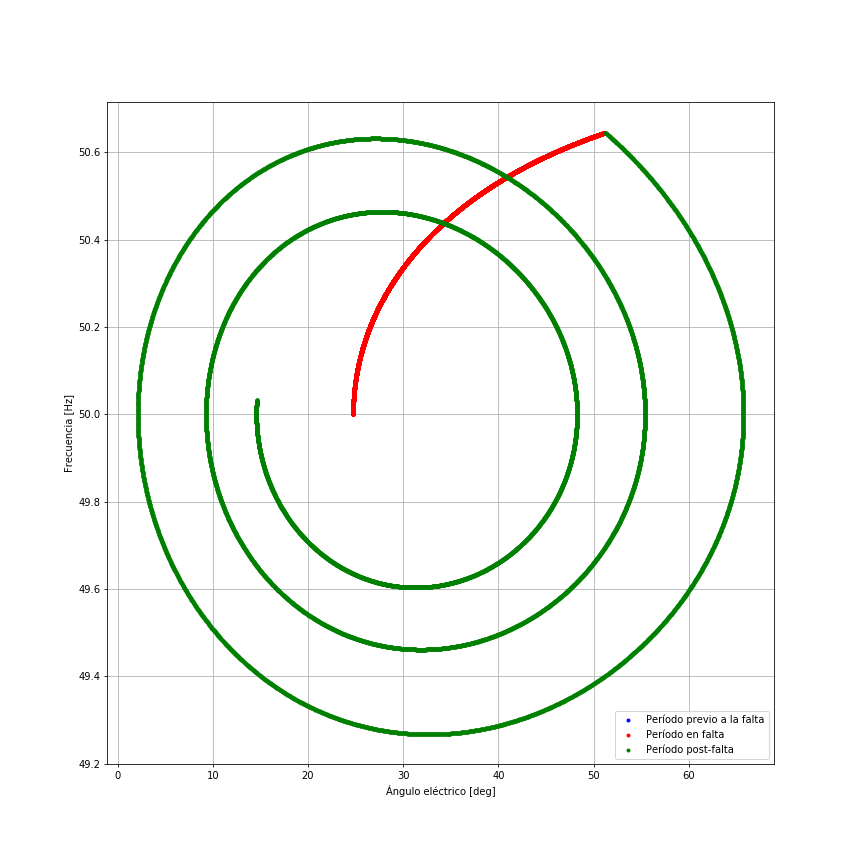

In [176]:
# Representación gráfica de las soluciones (ESPACIO DE ESTADOS):
anotaciones = True
fig1 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Frecuencia [Hz]')
plt.xlabel('Ángulo eléctrico [deg]')

## Período previo a la falta:
fppre = plt.plot((180/np.pi)*xy1_pref[:,0],xy1_pref[:,1]/(2*np.pi), 'bo', markersize=3, label = 'Período previo a la falta')

## Período en falta:
fpf = plt.plot((180/np.pi)*xy1_f[:,0],xy1_f[:,1]/(2*np.pi), 'ro', markersize=3, label = 'Período en falta')

## Período post-falta:
fppos = plt.plot((180/np.pi)*xy1_posf[:,0],xy1_posf[:,1]/(2*np.pi), 'go', markersize=3, label = 'Período post-falta')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')

plt.show()

### Evolución de la frecuencia eléctrica en el tiempo

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


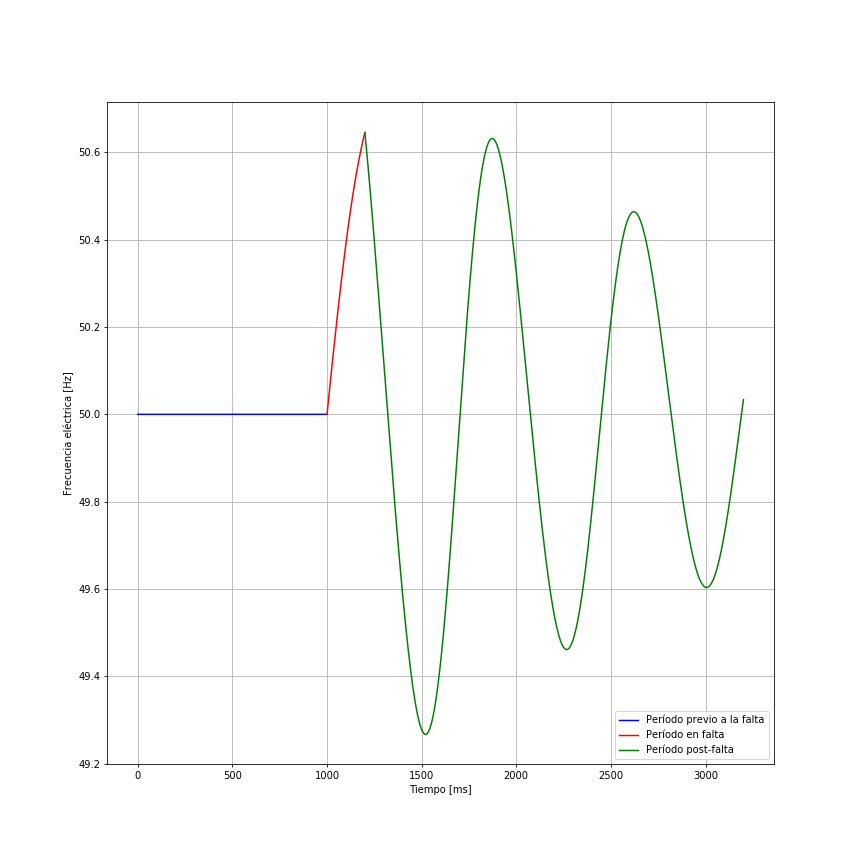

In [177]:
# Representación gráfica:
anotaciones = True
fig2 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Frecuencia eléctrica [Hz]')
plt.xlabel('Tiempo [ms]')

## Período previo a la falta:
ffrecpret = plt.plot(1000*t_pref,xy1_pref[:,1]/(2*np.pi),'b', label = 'Período previo a la falta')

## Período durante la falta:
ffrecft = plt.plot(1000*(t_pref[-1]+t_f),xy1_f[:,1]/(2*np.pi),'r', label = 'Período en falta')

## Período post-falta:
ffrecpost = plt.plot(1000*(t_pref[-1]+t_f[-1]+t_posf),xy1_posf[:,1]/(2*np.pi),'g', label = 'Período post-falta')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')

plt.show()

### Evolución del ángulo eléctrico en el tiempo

C:\Users\Miguel\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>


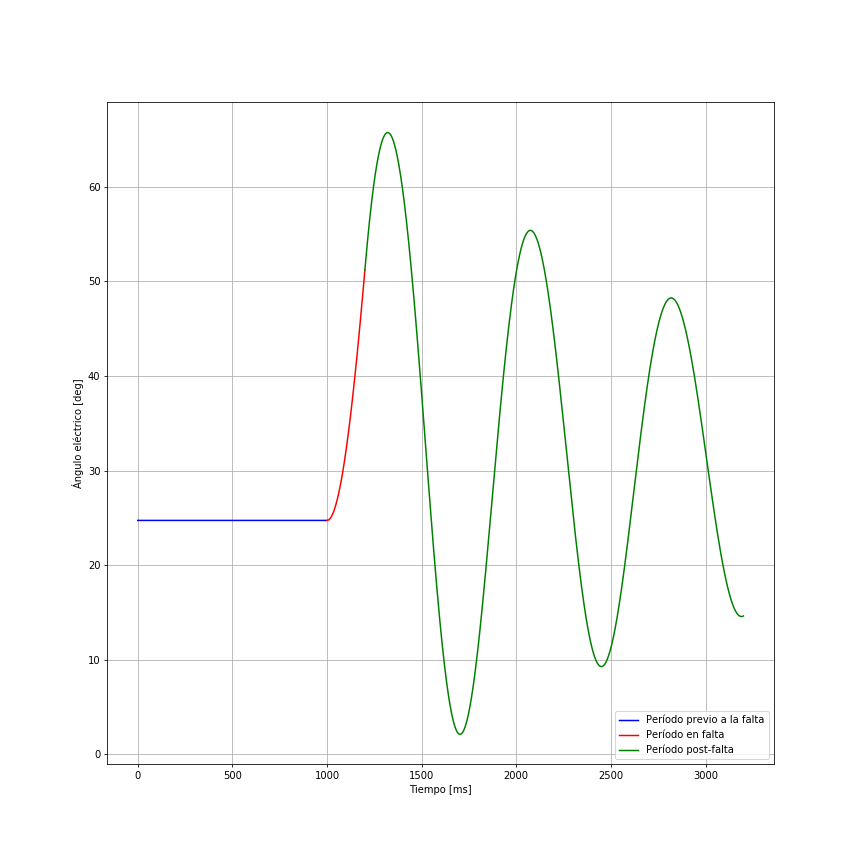

In [178]:
# Representación gráfica:
anotaciones = True
fig2 = plt.figure(figsize=(12,12),dpi= 80)
plt.grid()
plt.ylabel('Ángulo eléctrico [deg]')
plt.xlabel('Tiempo [ms]')

## Período previo a la falta:
fdeltapret = plt.plot(1000*t_pref,(180/np.pi)*xy1_pref[:,0],'b', label = 'Período previo a la falta')

## Período durante la falta:
fdeltaft = plt.plot(1000*(t_pref[-1]+t_f),(180/np.pi)*xy1_f[:,0],'r', label = 'Período en falta')

## Período post-falta:
fdeltapost = plt.plot(1000*(t_pref[-1]+t_f[-1]+t_posf),(180/np.pi)*xy1_posf[:,0],'g', label = 'Período post-falta')

# Leyenda del gráfico:
plt.legend(loc = 'lower right')

plt.show()